**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

# !pip install imbalanced-learn --user
#!pip install imblearn

In [3]:
import gc # сборщик мусора
import datetime # для работы со времнем
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, ShuffleSplit, learning_curve

import pickle
import random
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# клакстеризация
from sklearn.cluster import KMeans

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

0.7.0


In [4]:
DATASET_PATH = 'course_project_train.csv'
df = pd.read_csv(DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E346074E48>,
      dtype=object)

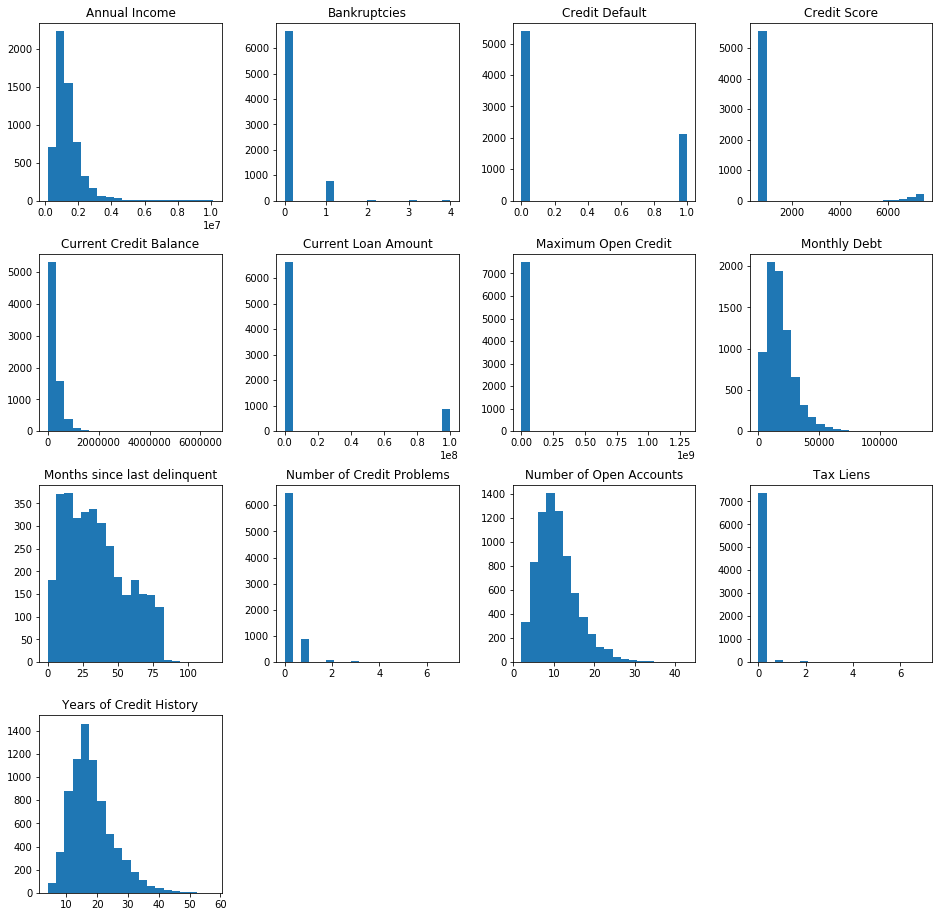

In [6]:
df.hist(figsize=(16,16), bins=20, grid=False)

In [7]:
TARGET_NAME = 'Credit Default'

In [8]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [9]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [10]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mins = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df.median()
        self.mins = df.min()

        
    def transform(self, df):
        """Трансформация данных"""

        # Исправляем выбросы по Credit Score - очевидно что там лишний ноль дописали 
        df.loc[(df['Credit Score']>850),'Credit Score'] = df['Credit Score']/10
        
        # Вместо Nan в "Months since last delinquent" ставим 0, так как логично допустить что когда нет просрочемк то и не вводили
        
        df.loc[(df['Months since last delinquent'].isnull()),'Months since last delinquent'] = 0
        
        # Аналогично по банкротствам
        df.loc[(df['Bankruptcies'].isnull()),'Bankruptcies'] = 0
        
        # Правим Credit Score и Annual Income у них Nan одновременно, что логично если не завели средний годовой доход то Credit Score не считается
        # Если количество месяцев просрочки меньше 1 и Years in current job не Null:
       
        df.loc[(df['Credit Score'].isnull()) & (df['Years in current job'].notnull()) &\
               (df['Months since last delinquent'] < 1),'Annual Income'] = df['Monthly Debt']*12
        
        df.loc[(df['Credit Score'].isnull()) & (df['Years in current job'].notnull()) &\
               (df['Months since last delinquent'] < 1),'Credit Score'] = self.medians['Credit Score']
        # Если количество месяцев просрочки больше 0 :
        df.loc[(df['Credit Score'].isnull()),['Annual Income','Credit Score']] = [0,self.mins['Credit Score']]
        
        # Правим Years in current job как меньшее из значений
        df.loc[(df['Years in current job'].isnull()),'Years in current job'] = '< 1 year'
        
        # Есть выбросы в Current Loan Amount ( = 99999999.0),но данная величина очень хорошо коррелирует с Credit Default = 0, 
        # так что оставим как есть
        # но оценив этот признак в разрезе целевой переменной получается что лучше переопределить этот показатель на 100 000
        # так с точки зрения распределения при увеличении Current Loan Amount идет увеличение Credit Default = 1
        df.loc[df['Current Loan Amount']> 1000000,'Current Loan Amount'] = 100000
        
        # КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
        # Объединим некоторые параметры в поле 'Years in current job'
        df.loc[df['Years in current job'].isin(['1 year','4 years','3 years']),'Years in current job'] = '2 years'
        df.loc[df['Years in current job'].isin(['6 years','7 years','8 years','9 years']),'Years in current job'] = '5 years'
        
        # Аналогично для Purpose
        df.loc[df['Purpose'].isin(['take a trip','buy a car','small business','business loan','wedding','educational expenses',\
                                   'buy house','medical bills','moving','major purchase','vacation', 'renewable energy']),'Purpose'] = 'other'
        
        # Объединим Home Mortgage' и 'Have Mortgage' в колонке 'Home Ownership'
        df.loc[df['Home Ownership'] == 'Have Mortgage','Home Ownership'] = 'Home Mortgage'
        return df


In [11]:
pipe = DataPipeline()
pipe.fit(df) # расчет статистик
df = pipe.transform(df)

In [12]:
df.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [13]:
# df.loc[(df['Credit Score']>850),'Credit Score'] = df['Credit Score']/10
# df.loc[(df['Months since last delinquent'].isnull()),'Months since last delinquent'] = 0
# df.loc[(df['Bankruptcies'].isnull()),'Bankruptcies'] = 0
# df.loc[(df['Credit Score'].isnull()),['Annual Income','Credit Score']] = [0,df['Credit Score'].min()]
# df.loc[(df['Years in current job'].isnull()),'Years in current job'] = '< 1 year'

In [14]:
DATASET_PATH = 'course_project_test.csv'
df1 = pd.read_csv(DATASET_PATH)
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [15]:
#pipe.fit(df1) # расчет статистик
df1 = pipe.transform(df1)

In [16]:
df1.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

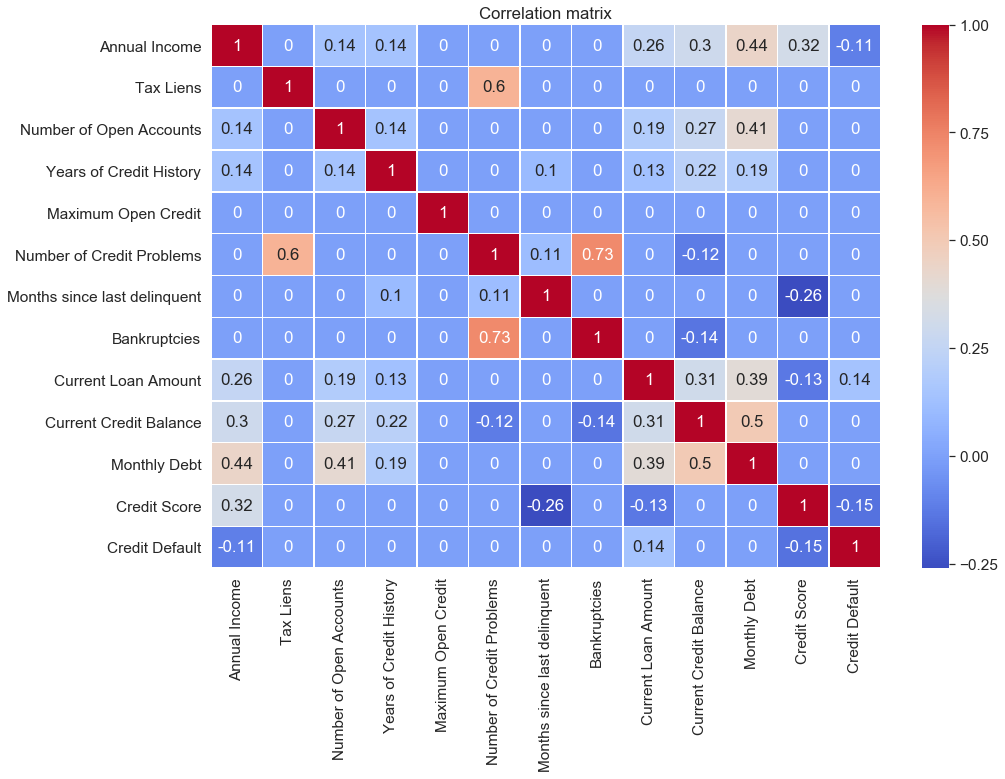

In [17]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

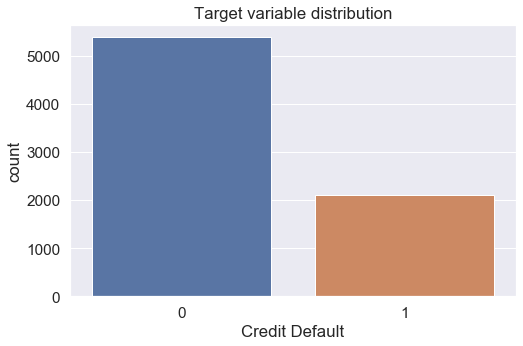

In [18]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

In [19]:
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

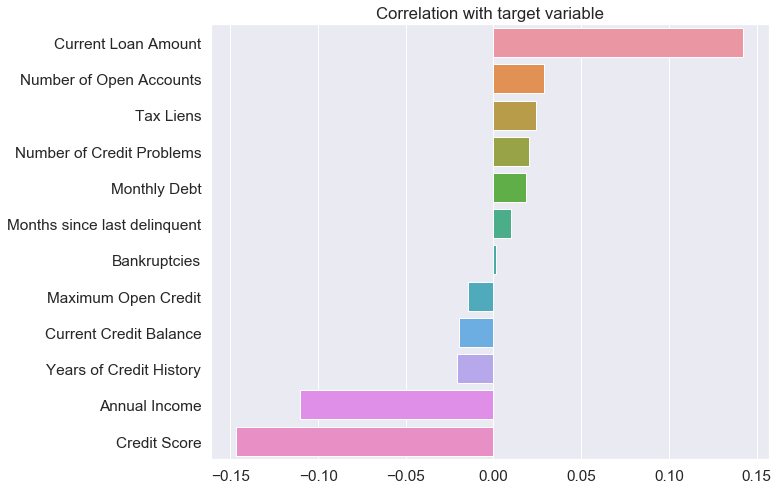

In [20]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

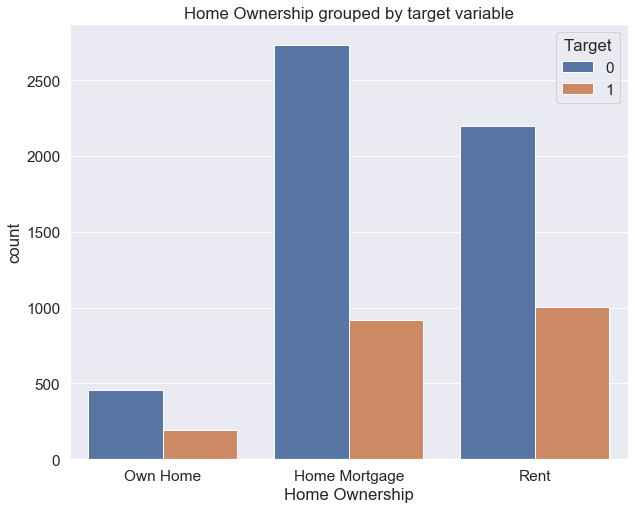

In [21]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [22]:
def countplot(df,vname,tname = TARGET_NAME):
    
    plt.figure(figsize=(10, 8))

    sns.countplot(x=vname, hue=TARGET_NAME, data=df)
    plt.title(f'{vname} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

In [23]:
df.select_dtypes(include='object')
CAT_FEATURES = df.select_dtypes(include='object').columns.tolist()
CAT_FEATURES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

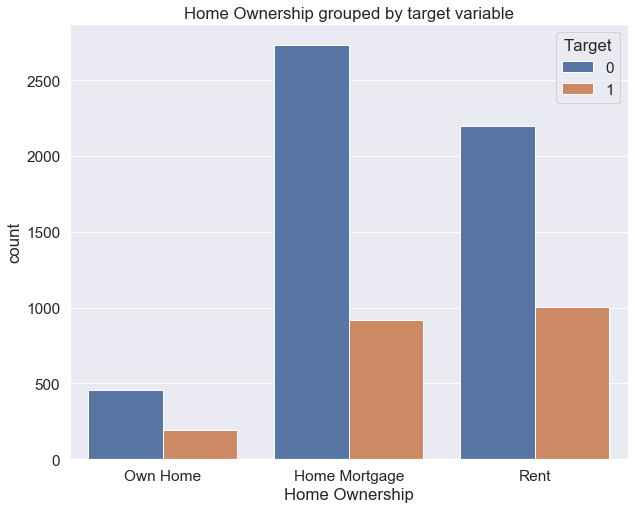

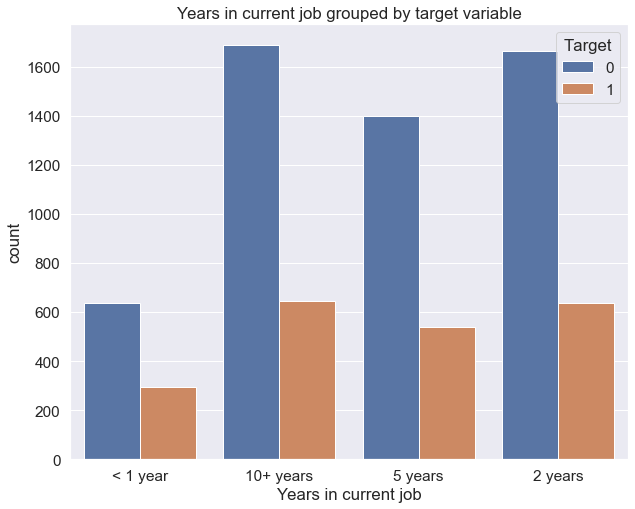

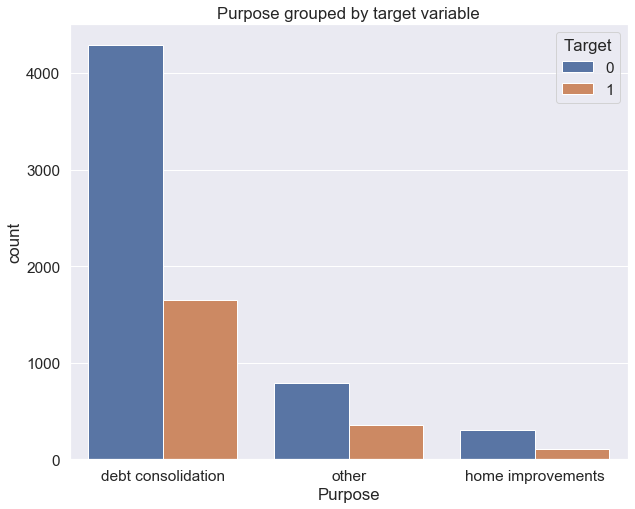

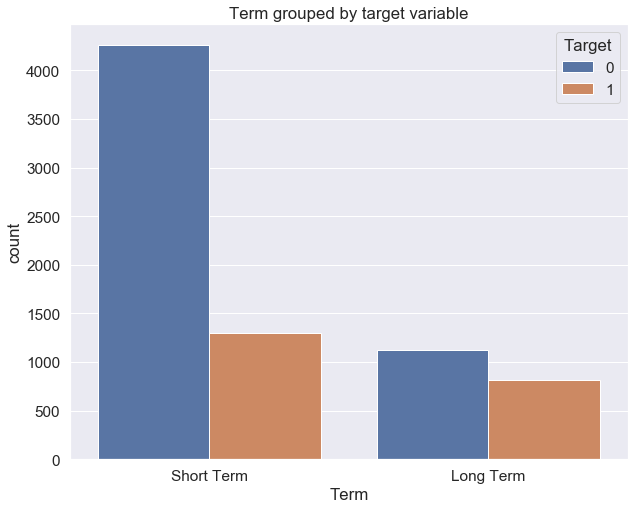

In [24]:
for vname in CAT_FEATURES:
    countplot(df,vname)

In [25]:
df1['Purpose'].value_counts()

debt consolidation    1973
other                  387
home improvements      140
Name: Purpose, dtype: int64

In [26]:
var_p = pd.unique(df['Purpose']).tolist()
print(f'name\t\t0\t\t1\t\trate')
for i in var_p:
    c0 = df.loc[(df['Purpose'] == i) & (df[TARGET_NAME] == 0),'Purpose'].count()
    c1 = df.loc[(df['Purpose'] == i) & (df[TARGET_NAME] == 1),'Purpose'].count()
    print(f'{c0+c1}\t\t{c0}\t\t{c1}\t\t{c1/(c0)}\t\t{i}')
var_p

name		0		1		rate
5944		4290		1654		0.38554778554778557		debt consolidation
1144		793		351		0.4426229508196721		other
412		304		108		0.35526315789473684		home improvements


['debt consolidation', 'other', 'home improvements']

Имеет смысл оставить только три группы: debt consolidation, other, home improvements

In [27]:
NUM_FEATURES = df.columns.drop(CAT_FEATURES +[TARGET_NAME]).tolist()
NUM_FEATURES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [28]:
def plot_by_target(df,vname,tname):
    X = df[[vname, tname]]
    X_0 = X.loc[X[tname]==0,vname]
    X_1 = X.loc[X[tname]==1,vname]
    
    plt.figure(figsize=(10, 5))

    sns.kdeplot(X_0, shade=True, label='No default', color='g')
    sns.kdeplot(X_1, shade=True, label='Default', color='r')

    plt.xlabel(f'{vname}')
    plt.title(f'{vname} grouped by target variable')
    plt.show()


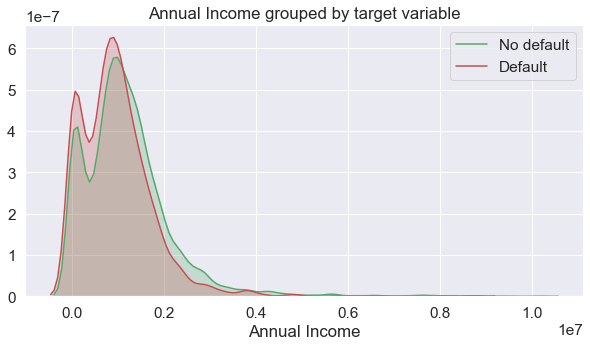

In [29]:
plot_by_target(df,'Annual Income',TARGET_NAME)

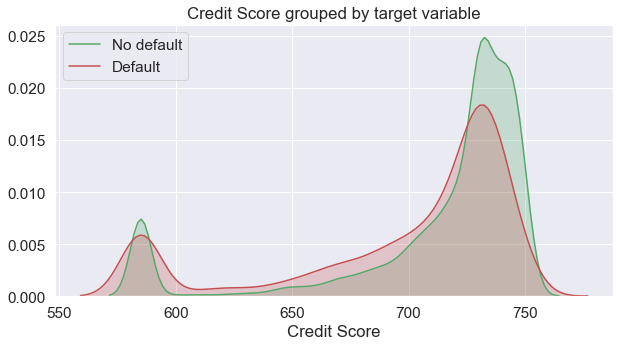

In [30]:
plot_by_target(df,'Credit Score',TARGET_NAME)

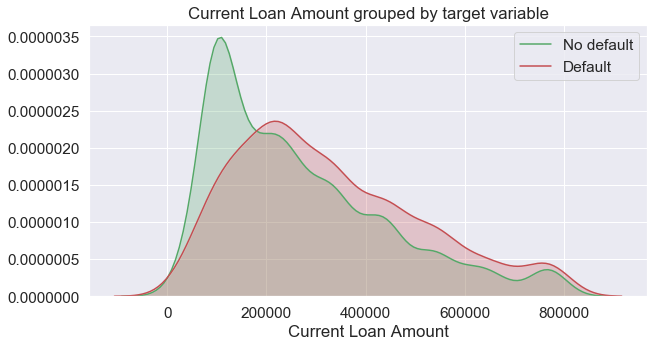

In [31]:
plot_by_target(df,'Current Loan Amount',TARGET_NAME)

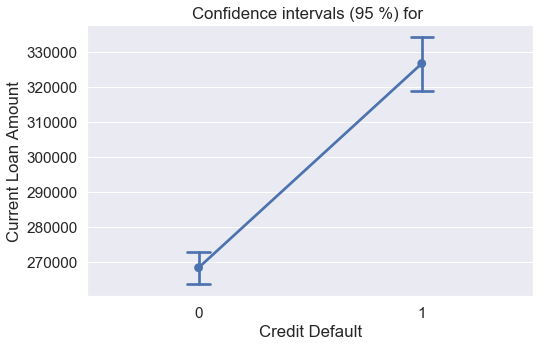

In [32]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=df[df['Current Loan Amount']<1000000], capsize=.1)

plt.title('Confidence intervals (95 %) for ')
plt.show()

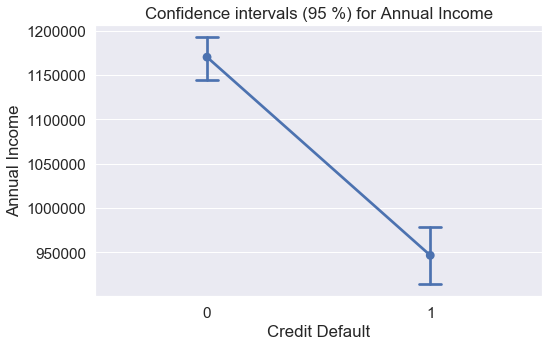

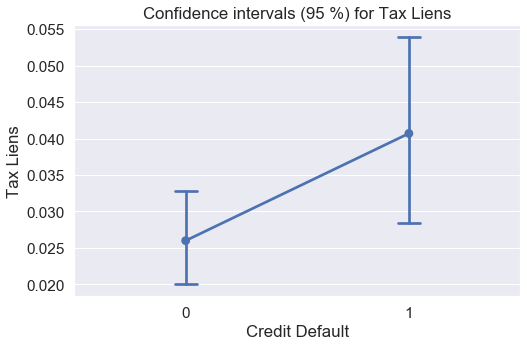

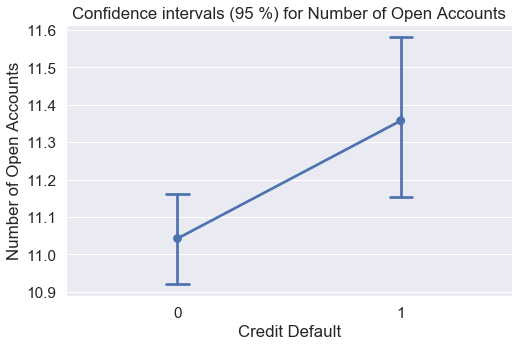

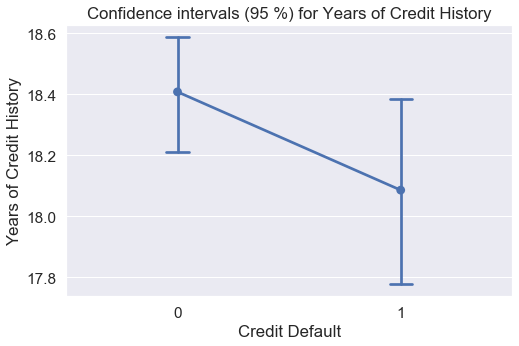

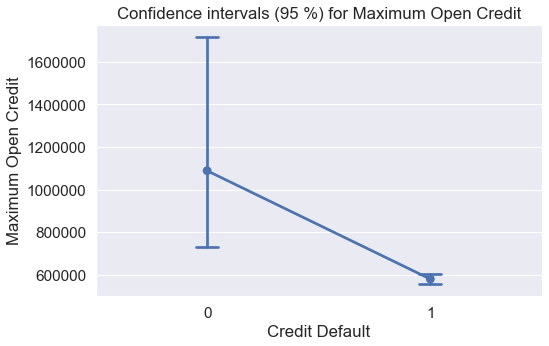

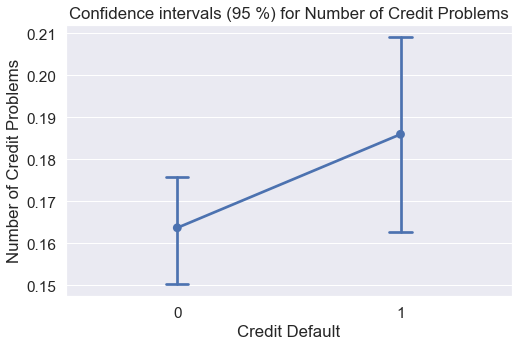

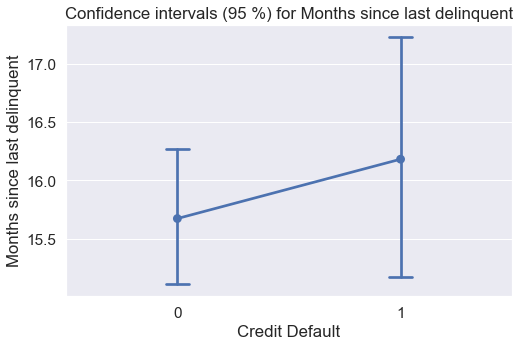

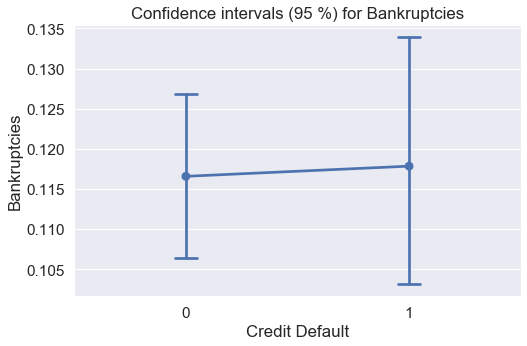

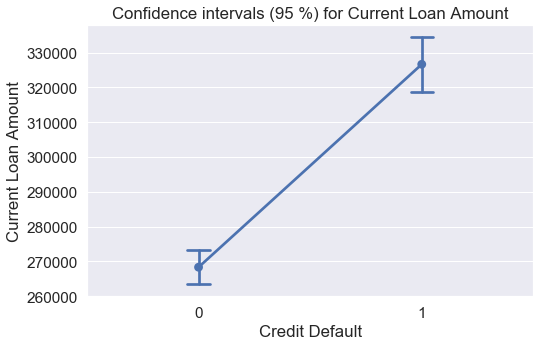

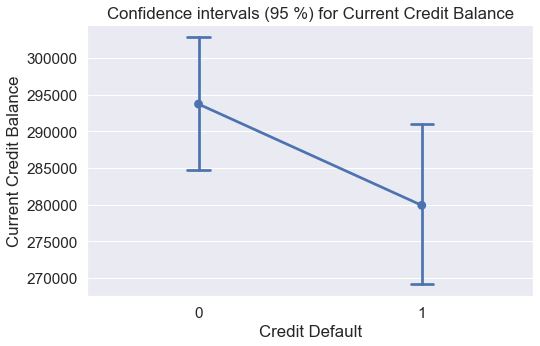

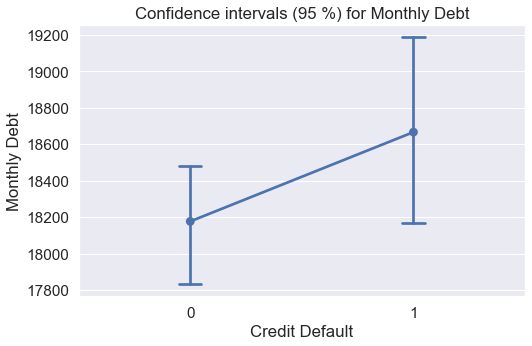

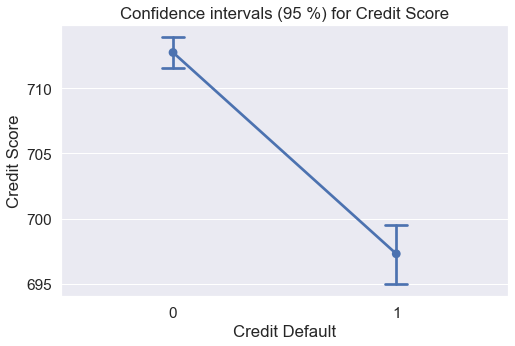

In [33]:
for vname in NUM_FEATURES:
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=TARGET_NAME, y=vname, data=df, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {vname}')
    plt.show()

Построив доверительные интервалы для средних значений, каждой из двух групп по целевой переменной и сравнимв их, получаем что: параметры: 'Annual Income','Maximum Open Credit', 'Maximum Open Credit','Current Loan Amount','Credit Score' имеют различные распределения (у них даже доверительные интервалы не пересекаются) и эти признаки может быть полезен для определения значения целевой переменной.
Остальные параметры хотя средние величины и отличаются но имеют пересекающиеся области доверительных интеравалов, что говорит о более слабом характере влияния этих параметров на целевую переменную.
А у параметра  'Bankruptcies'даже средняя величина мало отличается (что может быть еще связано с тем что очень большой перекос по количеству отличных от 0 значений)

-------
#### Проведем оценку распределений для тестового и тренировочного наборов

In [34]:
X_train = df.drop(TARGET_NAME,axis = 1)


In [35]:
X_train['db'] = 'train'

In [36]:
X_test = df1.copy()
X_test['db'] = 'test'
X_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,db
0,Rent,0.0,2 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,585.0,test
1,Rent,231838.0,2 years,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,other,Short Term,78298.0,46037.0,2318.0,699.0,test
2,Home Mortgage,1152540.0,2 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,test
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,test
4,Home Mortgage,2340952.0,5 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,test


In [37]:
X = pd.concat([X_train,X_test])

In [38]:
X.shape

(10000, 17)

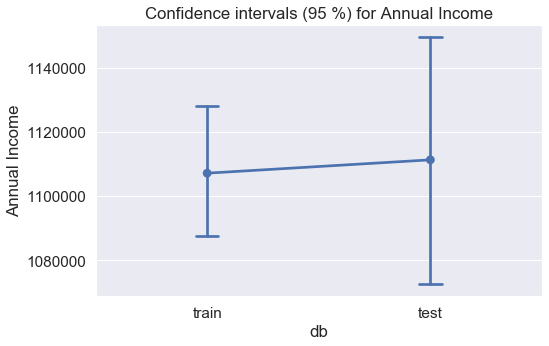

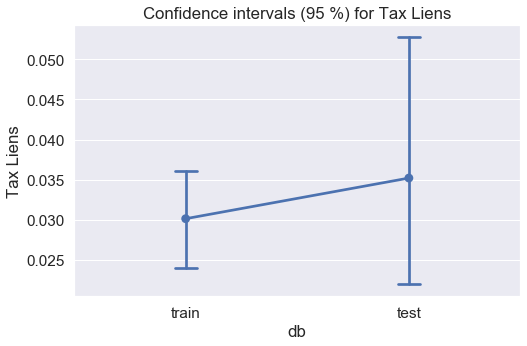

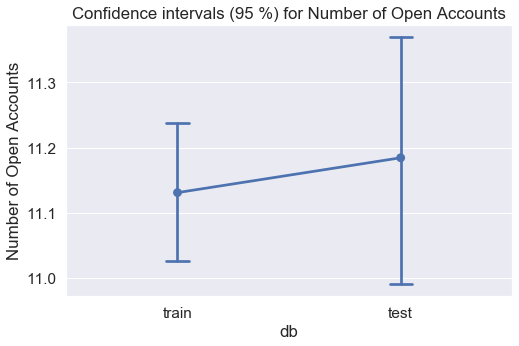

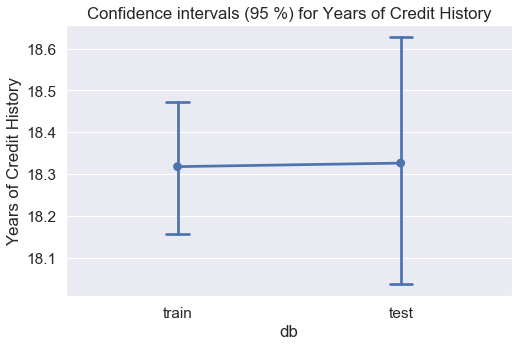

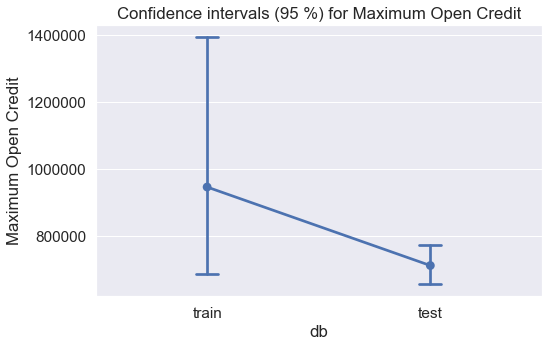

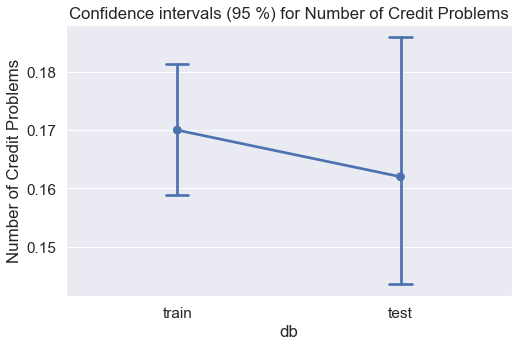

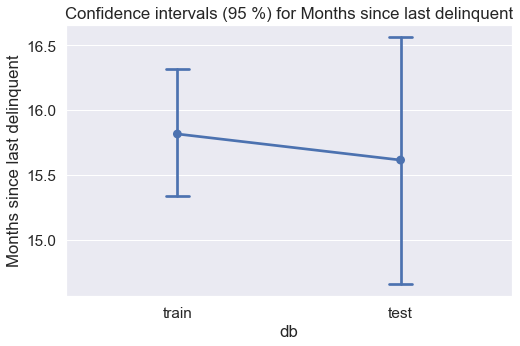

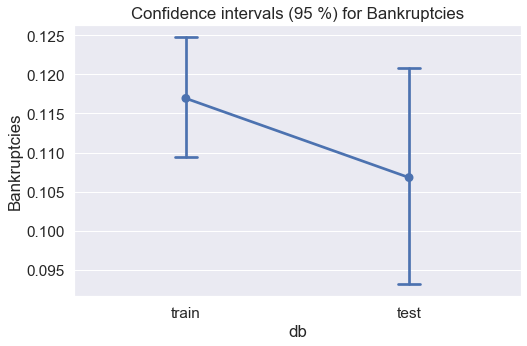

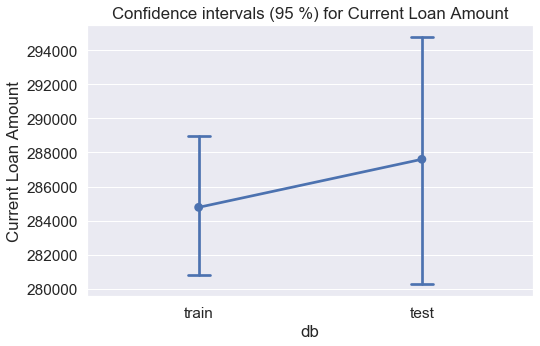

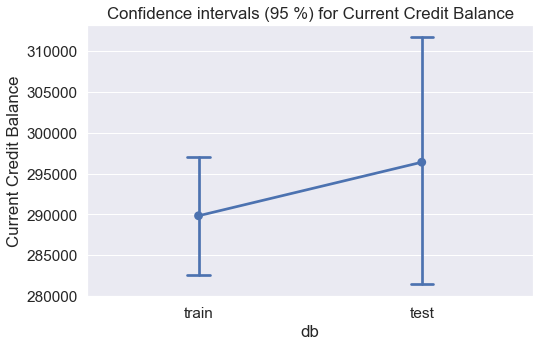

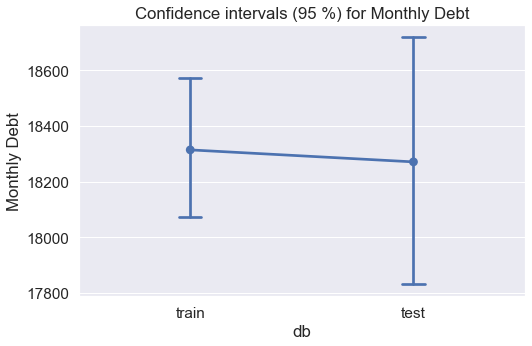

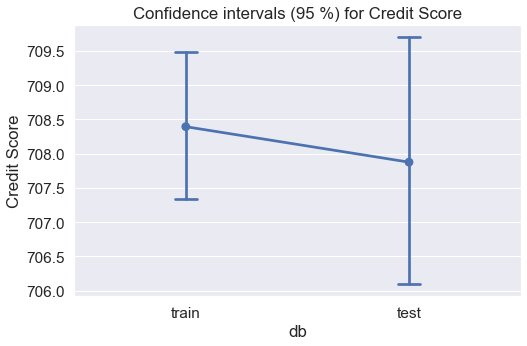

In [39]:
for vname in NUM_FEATURES:
    plt.figure(figsize=(8, 5))

    sns.pointplot(x='db', y=vname, data=X, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {vname}')
    plt.show()

С учетом доверительных интервалов можно сказать что распределение параметров на тестовой и тренировочной базе соотвествуют друг другу. Хотя с учетом того что здесь наихудшая оценка в сравнении на тестовой и тренировочной выборке для "Bankruptcies" и учитывая доверительный интервал для целевых парметров - можно рекомендовать "Bankruptcies" не рассматривать для обучения



------

### Масштабирование

In [40]:
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURES] = scaler.fit_transform(df_norm[NUM_FEATURES])

df = df_norm.copy()
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,-0.687176,< 1 year,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,2.545732,debt consolidation,Short Term,-1.004283,-0.762772,-0.872085,0.857856,0
1,Own Home,-0.089775,10+ years,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.337099,debt consolidation,Long Term,-0.107667,0.330781,0.004909,0.604334,1
2,Home Mortgage,-0.391086,5 years,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,-0.337099,debt consolidation,Short Term,-1.004283,0.058379,-0.391034,0.709968,0
3,Own Home,-0.332098,5 years,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,2.545732,debt consolidation,Short Term,-0.887994,-0.610282,-0.584980,-0.304119,0
4,Rent,-0.363765,5 years,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-0.337099,debt consolidation,Short Term,-0.863840,-0.618292,-0.933631,0.224051,0


In [41]:
df_norm1 = df1.copy()
df_norm1[NUM_FEATURES] = scaler.transform(df_norm1[NUM_FEATURES])

df1 = df_norm1.copy()
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,-1.217172,2 years,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,2.392483,-0.337099,debt consolidation,Short Term,-0.664753,-0.578660,-0.964404,-2.606943
1,Rent,-0.962294,2 years,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.345073,-0.337099,other,Short Term,-1.122236,-0.767016,-1.341313,-0.198485
2,Home Mortgage,0.049904,2 years,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.698307,-0.337099,debt consolidation,Short Term,-0.459806,-0.450977,0.034760,0.371939
3,Home Mortgage,0.124413,10+ years,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,2.392483,-0.337099,debt consolidation,Short Term,-0.366301,-0.241102,0.775161,0.646588
4,Home Mortgage,1.356417,5 years,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.698307,-0.337099,debt consolidation,Long Term,2.678720,0.426483,2.036777,-0.050597


### Reduce

In [42]:
FEATURES_PCA = [
#                 'Annual Income',  
                'Tax Liens',
                'Number of Open Accounts',
                'Years of Credit History',
#                 'Maximum Open Credit',
                'Number of Credit Problems',
                'Months since last delinquent',
                'Bankruptcies',
#                 'Current Loan Amount',
                'Current Credit Balance',
                'Monthly Debt',
#                 'Credit Score'
               ]

In [43]:
pca_trans = PCA(n_components=2)
X_new_PCA= pca_trans.fit_transform(df.loc[:,FEATURES_PCA].values)
X_new_PCA

array([[ 2.55496512e+00,  7.39849633e-01],
       [-7.63724611e-01,  1.36006236e-02],
       [-5.42354305e-01,  3.60714164e-01],
       ...,
       [-7.22983150e-01,  4.70894554e-01],
       [-1.75402221e+00,  1.98903863e+00],
       [-5.86379702e-04, -1.41707316e+00]])

In [44]:
df['pca1']=X_new_PCA[:,0]
df['pca2']=X_new_PCA[:,1]
df.shape

(7500, 19)

In [45]:
X_new_PCA_t= pca_trans.transform(df1.loc[:,FEATURES_PCA].values)
df1['pca1']=X_new_PCA_t[:,0]
df1['pca2']=X_new_PCA_t[:,1]
df1.shape

(2500, 18)

### Dummies

In [46]:
for cat_colname in CAT_FEATURES:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_5 years,Years in current job_< 1 year,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Term_Long Term,Term_Short Term
0,Own Home,-0.687176,< 1 year,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.698307,2.545732,...,0,0,0,0,1,1,0,0,0,1
1,Own Home,-0.089775,10+ years,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.698307,-0.337099,...,0,1,0,0,0,1,0,0,1,0
2,Home Mortgage,-0.391086,5 years,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.698307,-0.337099,...,0,0,0,1,0,1,0,0,0,1
3,Own Home,-0.332098,5 years,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.698307,2.545732,...,0,0,0,1,0,1,0,0,0,1
4,Rent,-0.363765,5 years,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.698307,-0.337099,...,1,0,0,1,0,1,0,0,0,1


In [47]:
for cat_colname in CAT_FEATURES:
    df1 = pd.concat([df1, pd.get_dummies(df1[cat_colname], prefix=cat_colname)], axis=1)
df1.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Rent,Years in current job_10+ years,Years in current job_2 years,Years in current job_5 years,Years in current job_< 1 year,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Term_Long Term,Term_Short Term
0,Rent,-1.217172,2 years,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,2.392483,-0.337099,...,1,0,1,0,0,1,0,0,0,1
1,Rent,-0.962294,2 years,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.345073,-0.337099,...,1,0,1,0,0,0,0,1,0,1
2,Home Mortgage,0.049904,2 years,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.698307,-0.337099,...,0,0,1,0,0,1,0,0,0,1
3,Home Mortgage,0.124413,10+ years,-0.110953,0.991947,-0.187101,-0.030505,-0.340979,2.392483,-0.337099,...,0,1,0,0,0,1,0,0,0,1
4,Home Mortgage,1.356417,5 years,-0.110953,-0.026674,0.750203,0.016357,-0.340979,-0.698307,-0.337099,...,0,0,0,1,0,1,0,0,1,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
Home Ownership                    7500 non-null object
Annual Income                     7500 non-null float64
Years in current job              7500 non-null object
Tax Liens                         7500 non-null float64
Number of Open Accounts           7500 non-null float64
Years of Credit History           7500 non-null float64
Maximum Open Credit               7500 non-null float64
Number of Credit Problems         7500 non-null float64
Months since last delinquent      7500 non-null float64
Bankruptcies                      7500 non-null float64
Purpose                           7500 non-null object
Term                              7500 non-null object
Current Loan Amount               7500 non-null float64
Current Credit Balance            7500 non-null float64
Monthly Debt                      7500 non-null float64
Credit Score                      7500 non-null float64
C

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
Home Ownership                    2500 non-null object
Annual Income                     2500 non-null float64
Years in current job              2500 non-null object
Tax Liens                         2500 non-null float64
Number of Open Accounts           2500 non-null float64
Years of Credit History           2500 non-null float64
Maximum Open Credit               2500 non-null float64
Number of Credit Problems         2500 non-null float64
Months since last delinquent      2500 non-null float64
Bankruptcies                      2500 non-null float64
Purpose                           2500 non-null object
Term                              2500 non-null object
Current Loan Amount               2500 non-null float64
Current Credit Balance            2500 non-null float64
Monthly Debt                      2500 non-null float64
Credit Score                      2500 non-null float64
p

In [50]:
NUM_FEATURES = df.columns.drop(CAT_FEATURES +[TARGET_NAME]).tolist()
NUM_FEATURES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'pca1',
 'pca2',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_5 years',
 'Years in current job_< 1 year',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_other',
 'Term_Long Term',
 'Term_Short Term']

----

### Выбор переменных и train_test_split

In [51]:
SELECTED_FEATURE_NAMES = [
    'Annual Income',
#      'Tax Liens',
     'Number of Open Accounts',
     'Years of Credit History',
     'Maximum Open Credit',
#      'Number of Credit Problems',
     'Months since last delinquent',
#      'Bankruptcies',
     'Current Loan Amount',
     'Current Credit Balance',
#      'Monthly Debt',
     'Credit Score',
     'pca1',
     'pca2',
     'Home Ownership_Home Mortgage',
     'Home Ownership_Own Home',
     'Home Ownership_Rent',
     'Years in current job_10+ years',
     'Years in current job_2 years',
     'Years in current job_5 years',
     'Years in current job_< 1 year',
     'Purpose_debt consolidation',
     'Purpose_home improvements',
     'Purpose_other',
     'Term_Long Term',
     'Term_Short Term'
]



In [52]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

##### Балансировка

In [53]:
oversample = SMOTE(k_neighbors=3)
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)
print('до баллансировки :',np.sum(y_train))
print('после баллансировки :',np.sum(y_train_bal))

до баллансировки : 1455
после баллансировки : 3795


In [54]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print(f'F1-score = {f1_score(y_test_true, y_test_pred)}\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### LogisticRegression

In [55]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3795
           1       0.57      0.15      0.24      1455

    accuracy                           0.73      5250
   macro avg       0.66      0.55      0.54      5250
weighted avg       0.70      0.73      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.95      0.83      1592
           1       0.55      0.14      0.23       658

    accuracy                           0.72      2250
   macro avg       0.64      0.55      0.53      2250
weighted avg       0.68      0.72      0.65      2250

F1-score = 0.22705314009661837

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1516  76
1                564  94


In [56]:
model_lr = LogisticRegression()
model_lr.fit(X_train_bal, y_train_bal)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      3795
           1       0.44      0.44      0.44      1455

    accuracy                           0.69      5250
   macro avg       0.61      0.61      0.61      5250
weighted avg       0.69      0.69      0.69      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1592
           1       0.44      0.41      0.42       658

    accuracy                           0.68      2250
   macro avg       0.60      0.60      0.60      2250
weighted avg       0.67      0.68      0.67      2250

F1-score = 0.42371541501976284

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1253  339
1                390  268


#### KNeighborsClassifier

In [57]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3795
           1       0.68      0.38      0.49      1455

    accuracy                           0.78      5250
   macro avg       0.74      0.66      0.67      5250
weighted avg       0.76      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1592
           1       0.41      0.22      0.29       658

    accuracy                           0.68      2250
   macro avg       0.57      0.54      0.54      2250
weighted avg       0.64      0.68      0.65      2250

F1-score = 0.2857142857142857

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1386  206
1                514  144


In [58]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_bal, y_train_bal)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      3795
           1       0.57      0.88      0.69      1455

    accuracy                           0.78      5250
   macro avg       0.75      0.81      0.76      5250
weighted avg       0.84      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.62      0.68      1592
           1       0.35      0.50      0.41       658

    accuracy                           0.58      2250
   macro avg       0.55      0.56      0.54      2250
weighted avg       0.63      0.58      0.60      2250

F1-score = 0.40954773869346733

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               984  608
1               332  326


In [151]:
# model_xgb = xgb.XGBClassifier(random_state=21)
# model_xgb.fit(X_train, y_train)

# y_train_pred = model_xgb.predict(X_train)
# y_test_pred = model_xgb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

#### LGBMClassifier

In [59]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.99      0.94      3795
           1       0.97      0.66      0.79      1455

    accuracy                           0.90      5250
   macro avg       0.93      0.83      0.86      5250
weighted avg       0.91      0.90      0.89      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1592
           1       0.52      0.24      0.33       658

    accuracy                           0.71      2250
   macro avg       0.63      0.57      0.57      2250
weighted avg       0.68      0.71      0.67      2250

F1-score = 0.3305785123966942

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1442  150
1                498  160


In [60]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=80,  
                                  max_depth=3,                                  
                                  min_samples_leaf=10,
                                 random_state=42)
# model_lgbm = lgbm.LGBMClassifier(n_estimators=400,  
#                                   max_depth=15,                                  
#                                   min_samples_leaf=5,
#                                  random_state=42)
# model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train_bal, y_train_bal)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      3795
           1       0.47      0.64      0.54      1455

    accuracy                           0.70      5250
   macro avg       0.65      0.68      0.66      5250
weighted avg       0.74      0.70      0.71      5250

TEST

              precision    recall  f1-score   support

           0       0.79      0.69      0.73      1592
           1       0.42      0.55      0.48       658

    accuracy                           0.65      2250
   macro avg       0.60      0.62      0.61      2250
weighted avg       0.68      0.65      0.66      2250

F1-score = 0.477946017116524

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1094  498
1                295  363


#### CatBoostClassifier

In [61]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3795
           1       0.94      0.52      0.67      1455

    accuracy                           0.86      5250
   macro avg       0.89      0.75      0.79      5250
weighted avg       0.87      0.86      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1592
           1       0.56      0.19      0.28       658

    accuracy                           0.72      2250
   macro avg       0.65      0.56      0.56      2250
weighted avg       0.69      0.72      0.67      2250

F1-score = 0.2840909090909091

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1495   97
1                533  125


In [62]:
model_catb = catb.CatBoostClassifier(silent=True, n_estimators=200,  
                                  max_depth=10, random_state=42)
model_catb.fit(X_train_bal, y_train_bal)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3795
           1       1.00      0.99      1.00      1455

    accuracy                           1.00      5250
   macro avg       1.00      1.00      1.00      5250
weighted avg       1.00      1.00      1.00      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1592
           1       0.44      0.32      0.37       658

    accuracy                           0.68      2250
   macro avg       0.59      0.58      0.58      2250
weighted avg       0.66      0.68      0.66      2250

F1-score = 0.3706293706293706

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1318  274
1                446  212


In [64]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 5.0], silent=True, n_estimators=200,  
                                   max_depth=7,random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.64      0.78      3795
           1       0.52      1.00      0.68      1455

    accuracy                           0.74      5250
   macro avg       0.76      0.82      0.73      5250
weighted avg       0.87      0.74      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.51      0.63      1592
           1       0.39      0.75      0.51       658

    accuracy                           0.58      2250
   macro avg       0.61      0.63      0.57      2250
weighted avg       0.70      0.58      0.60      2250

F1-score = 0.5108359133126935

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               807  785
1               163  495


In [63]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.0], silent=True, n_estimators=200,  
#                                   max_depth=10, random_state=42)
model_catb_cw = catb.CatBoostClassifier(class_weights=[1, 3.0], silent=True, random_state=42)
model_catb_cw.fit(X_train_bal, y_train_bal)

y_train_pred = model_catb_cw.predict(X_train)
y_test_pred = model_catb_cw.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      3795
           1       0.51      0.99      0.67      1455

    accuracy                           0.73      5250
   macro avg       0.75      0.81      0.72      5250
weighted avg       0.86      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.50      0.63      1592
           1       0.38      0.75      0.51       658

    accuracy                           0.58      2250
   macro avg       0.61      0.63      0.57      2250
weighted avg       0.70      0.58      0.59      2250

F1-score = 0.5077239958805355

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               801  791
1               165  493


#### RandomForestClassifier

In [65]:
model_rf = RandomForestClassifier(n_estimators=120,  
                                  max_depth=6,                                  
                                  min_samples_leaf=6,
                                  random_state=42)

model_rf.fit(X_train, y_train)

y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      3795
           1       0.85      0.13      0.23      1455

    accuracy                           0.75      5250
   macro avg       0.80      0.56      0.54      5250
weighted avg       0.78      0.75      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1592
           1       0.63      0.08      0.14       658

    accuracy                           0.72      2250
   macro avg       0.68      0.53      0.49      2250
weighted avg       0.69      0.72      0.63      2250

F1-score = 0.14285714285714285

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1561  31
1                605  53


In [66]:
model_rf = RandomForestClassifier(n_estimators=300,  
                                  max_depth=30,                                  
                                  min_samples_leaf=7,
                                  random_state=42)
# model_rf = RandomForestClassifier(n_estimators=100,  
#                                   max_depth=5,                                  
#                                   min_samples_leaf=15,
#                                   random_state=42)

model_rf.fit(X_train_bal, y_train_bal)

y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3795
           1       0.80      0.86      0.83      1455

    accuracy                           0.90      5250
   macro avg       0.87      0.89      0.88      5250
weighted avg       0.90      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1592
           1       0.43      0.47      0.45       658

    accuracy                           0.66      2250
   macro avg       0.60      0.61      0.61      2250
weighted avg       0.67      0.66      0.67      2250

F1-score = 0.45203488372093026

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1185  407
1                347  311


### SVM

In [67]:
from sklearn import svm

cSVM = svm.SVC()
cSVM.fit(X_train_bal, y_train_bal)


y_train_pred = cSVM.predict(X_train)
y_test_pred= cSVM.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      3795
           1       0.53      0.55      0.54      1455

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1592
           1       0.42      0.39      0.41       658

    accuracy                           0.67      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.66      0.67      0.66      2250

F1-score = 0.4081954294720252

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1240  352
1                399  259


### Подбор параметров

In [68]:
params = {'n_estimators':[50, 100, 150, 200, 250, 300, 400], 
          'max_depth':[5, 7, 10, 15, 20, 30],
          'min_samples_leaf': [7,10,30]}

gs = GridSearchCV(model_rf, params, 
                  scoring='f1', # метрика 
                  cv=KFold(n_splits=4,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
#gs.fit(X_train, y_train)  # НА TRAIN!
gs.fit(X_train_bal, y_train_bal)  # НА TRAIN!
gs.best_params_, gs.best_score_

({'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 400},
 0.7735592750322277)

In [69]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.331864,0.018245,0.017202,0.000431,5,7,50,"{'max_depth': 5, 'min_samples_leaf': 7, 'n_est...",0.687911,0.710826,0.701020,0.693119,0.698219,0.008646,119
1,0.671703,0.037698,0.034409,0.005751,5,7,100,"{'max_depth': 5, 'min_samples_leaf': 7, 'n_est...",0.686354,0.708018,0.696215,0.698603,0.697298,0.007706,122


In [70]:
%%time
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7,10]}
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                       )
rs.fit(X_train_bal, y_train_bal)
rs.best_params_, rs.best_score_

Wall time: 5min 24s


({'n_estimators': 1000, 'max_depth': 10}, 0.7768944402151069)

In [72]:
%%time
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7,10]}
rs = RandomizedSearchCV(model_catb_cw, params, scoring='f1', cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                       )
rs.fit(X_train_bal, y_train_bal)
rs.best_params_, rs.best_score_

Wall time: 3min


({'n_estimators': 700, 'max_depth': 10}, 0.797736900825882)

In [73]:
params = {'n_estimators':[50, 100, 150, 200, 250, 300, 400], 
          'max_depth':[5, 7, 10, 15, 20, 30],
          'min_samples_leaf': [5,10,20,30]}

gs = GridSearchCV(model_lgbm, params, 
                  scoring='f1', # метрика 
                  cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
#gs.fit(X_train, y_train)  # НА TRAIN!
gs.fit(X_train_bal, y_train_bal)  # НА TRAIN!
gs.best_params_, gs.best_score_

({'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 400},
 0.8009825930639941)

In [74]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_lgbm.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
5,Current Loan Amount,79
0,Annual Income,68
1,Number of Open Accounts,58
7,Credit Score,48
3,Maximum Open Credit,39
8,pca1,31
6,Current Credit Balance,29
21,Term_Short Term,19
15,Years in current job_5 years,18
4,Months since last delinquent,16


In [75]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_rf.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
5,Current Loan Amount,0.167546
7,Credit Score,0.120471
0,Annual Income,0.103655
3,Maximum Open Credit,0.072033
8,pca1,0.070128
6,Current Credit Balance,0.065988
9,pca2,0.065187
1,Number of Open Accounts,0.064582
2,Years of Credit History,0.061969
21,Term_Short Term,0.054654


In [76]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
5,Current Loan Amount,22.478739
0,Annual Income,10.541861
7,Credit Score,8.982394
3,Maximum Open Credit,8.038919
6,Current Credit Balance,7.756105
2,Years of Credit History,7.251025
9,pca2,7.068137
8,pca1,5.572160
1,Number of Open Accounts,4.720987
4,Months since last delinquent,4.170236


### CatBoostClassifier с обработкой категорийных параметров

In [77]:
SEL_FEATURES = ['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'pca1',
 'pca2']

In [78]:
X = df[SEL_FEATURES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

In [79]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 5.0], silent=True, random_state=42)
model_catb.fit(X_train, y_train, CAT_FEATURES)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.54      0.70      3795
           1       0.45      0.99      0.62      1455

    accuracy                           0.67      5250
   macro avg       0.72      0.77      0.66      5250
weighted avg       0.85      0.67      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.46      0.60      1592
           1       0.39      0.83      0.53       658

    accuracy                           0.57      2250
   macro avg       0.63      0.65      0.57      2250
weighted avg       0.73      0.57      0.58      2250

F1-score = 0.5303545410393394

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               737  855
1               112  546


-----

### Сравнение моделей

In [80]:
SELECTED_FEATURE_NAMES = [
     'Annual Income',
#      'Tax Liens',
     'Number of Open Accounts',
     'Years of Credit History',
     'Maximum Open Credit',
#      'Number of Credit Problems',
     'Months since last delinquent',
#      'Bankruptcies',
     'Current Loan Amount',
     'Current Credit Balance',
#      'Monthly Debt',
     'Credit Score',
     'pca1',
     'pca2',
     'Home Ownership_Home Mortgage',
     'Home Ownership_Own Home',
     'Home Ownership_Rent',
     'Years in current job_10+ years',
     'Years in current job_2 years',
     'Years in current job_5 years',
     'Years in current job_< 1 year',
     'Purpose_debt consolidation',
     'Purpose_home improvements',
     'Purpose_other',
     'Term_Long Term',
     'Term_Short Term'
]
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

# Балансировка
oversample = SMOTE(k_neighbors=3)
X_train_bal, y_train_bal = oversample.fit_resample(X_train, y_train)

# print('до баллансировки :',np.sum(y_train))
# print('после баллансировки :',np.sum(y_train_bal))

In [104]:
model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()
model_lgbm = lgbm.LGBMClassifier(n_estimators=80,  
                                  max_depth= 3,                                  
                                  min_samples_leaf= 25,
                                 random_state=42)
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb_cw = catb.CatBoostClassifier(class_weights=[1, 4.0], silent=True, n_estimators=700,  
                                  max_depth=10,  random_state=42)
model_rf = RandomForestClassifier(n_estimators=400,  
                                  max_depth=20,                                  
                                  min_samples_leaf=7,
                                  random_state=42)
cSVM = svm.SVC()

MODELS = {
    'LogisticRegression': model_lr,
    'KNeighborsClassifier': model_knn,
    'LGBMClassifier': model_lgbm,
    'CatBoostClassifier' : model_catb,
    'CatBoostClassifier_CW' : model_catb_cw,
    'RandomForestClassifier' : model_rf,
    'SVM' : cSVM
}

In [105]:
print('Model'.ljust(30),'F1-score test'.ljust(26),'F1-score train')
print('-'*80)
for i in MODELS:
    model = MODELS[i]
    model.fit(X_train_bal, y_train_bal)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
#     print(i.ljust(30), f'F1-score = {f1_score(y_test, y_test_pred)}')
    print(i.ljust(30), f'{f1_score(y_test, y_test_pred)}\t', f1_score(y_train, y_train_pred))

Model                          F1-score test              F1-score train
--------------------------------------------------------------------------------
LogisticRegression             0.43375394321766564	 0.44155844155844154
KNeighborsClassifier           0.40615384615384614	 0.6780912206696547
LGBMClassifier                 0.47643979057591623	 0.5468795355587809
CatBoostClassifier             0.3964912280701754	 0.7735849056603774
CatBoostClassifier_CW          0.4829239065308568	 0.9014869888475837
RandomForestClassifier         0.46613255644573925	 0.8207826372903649
SVM                            0.4129746835443038	 0.5401907356948229


Самыми перспективными выглядят следующие модели:

1. CatBoostClassifier_CW (с весом на целевой класс)
2. RandomForestClassifier
3. LGBMClassifier 


Кроме того стоит отметить что для CatBoostClassifier можно брать данные прямо с категорийными параметрами. 